# Fannie Mae Mortgae data analysis with H2O 

![](fannie.png)

This notebook contains code to analyse the Fannie Mae Single Family single rate mortgage data. See the following link on how to [download the data](https://www.fanniemae.com/portal/funding-the-market/data/loan-performance-data.html).

Per quarter there is a Acquisition data set and a Performance data set. For details [see here](https://www.fanniemae.com/resources/file/fundmarket/pdf/webinar-101.pdf)

When you download the data from the web site, it is a zip file per quarter (varying sizes ranging from 100 to 600 MB, the more recent quartwers are smaller) that contains an aquisition.txt and a performance.txt file. That is not convenient for importing the data. I want one zip file with all the performance.txt files, and one zip with all the acquistion.txt files.

If you have downloaded all the zip files (20**Q*.zip) in a directory, you can generate acquistion.zip and the performance.zip with the following commands:

In [1]:
%%time

### create a big zip for acquisition data and performance data from the downloaded zip files from the fannie mae website
!unzip '*.zip'
!zip acquisition.zip Acq*.txt
!zip performances.zip Perf*.txt

# The unzipped txt files are not needed anymore, I am making use of h2o, which can import zipped text files directly.
!rm *.txt

Archive:  2011Q1.zip
  inflating: Acquisition_2011Q1.txt
  inflating: Performance_2011Q1.txt

Archive:  2013Q3.zip
  inflating: Acquisition_2013Q3.txt
  inflating: Performance_2013Q3.txt

Archive:  2013Q2.zip
  inflating: Acquisition_2013Q2.txt
  inflating: Performance_2013Q2.txt

Archive:  2011Q2.zip
  inflating: Acquisition_2011Q2.txt
  inflating: Performance_2011Q2.txt

Archive:  2013Q1.zip
  inflating: Acquisition_2013Q1.txt
  inflating: Performance_2013Q1.txt

Archive:  2011Q3.zip
  inflating: Acquisition_2011Q3.txt
  inflating: Performance_2011Q3.txt

Archive:  2013Q4.zip
  inflating: Acquisition_2013Q4.txt
  inflating: Performance_2013Q4.txt

Archive:  2011Q4.zip
  inflating: Acquisition_2011Q4.txt
  inflating: Performance_2011Q4.txt

Archive:  2010Q2.zip
  inflating: Acquisition_2010Q2.txt
  inflating: Performance_2010Q2.txt

Archive:  2010Q3.zip
  inflating: Acquisition_2010Q3.txt
  inflating: Performance_2010Q3.txt

Archive:  2012Q1.zip
  inflating: Acquisition_2012Q1.txt
  i

Doing this only for the years 2010, 2011, 2012, 2013 and 2014 takes almost half an hour and results in an acquisition.zip file of 231 MB and a performance.zip file of 6.8 GB. When you download more or all the quarters from the fanniemae website, there might be too much data for your laptop too handle. You may need to spin up a "super computer" on a cloud platform, say GCP, my favourite :-)

In [2]:
## imports
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import h2o
import pandas as pd

In [3]:
%%capture

#### Set up h2o
h2o.init(max_mem_size="12G");

## Acquisition data
Each row in the acquistion file is a mortage.

### Import from zip

In [10]:
%%time
acquisitions_Variables = [
    "LOAN_ID", "ORIG_CHN", "Seller_Name", "ORIG_RT", "ORIG_AMT", "ORIG_TRM", "ORIG_DTE",
    "FRST_DTE", "OLTV", "OCLTV", "NUM_BO", "Debt_to_Income", "Borrower_Credit_Score", "FTHB_FLG", "PURPOSE", "PROPERTY_TYPE",
    "NUM_UNIT", "OCC_STAT", "STATE", "ZIP_3", "MI_PCT", "Product_Type", "CSCORE_C", "MI_TYPE", "RELOC"
]

acquisition = h2o.import_file(
    "data/acquisition2010_2014.zip",
    sep = "|",
    header = -1 ,
    col_names = acquisitions_Variables
)

acquisition.shape

Parse progress: |█████████████████████████████████████████████████████████| 100%
CPU times: user 370 ms, sys: 83.9 ms, total: 454 ms
Wall time: 35.7 s


(9930484, 25)

### some explorations

In [11]:
#### first five records
acquisition.head(5)

LOAN_ID,ORIG_CHN,Seller_Name,ORIG_RT,ORIG_AMT,ORIG_TRM,ORIG_DTE,FRST_DTE,OLTV,OCLTV,NUM_BO,Debt_to_Income,Borrower_Credit_Score,FTHB_FLG,PURPOSE,PROPERTY_TYPE,NUM_UNIT,OCC_STAT,STATE,ZIP_3,MI_PCT,Product_Type,CSCORE_C,MI_TYPE,RELOC
1.0001e+11,C,"WELLS FARGO BANK, N.A.",4.875,284000,360,01/2010,03/2010,80,80,1,32,773,Y,P,PU,1,P,TX,787,nan,FRM,nan,nan,N
1.00014e+11,R,"JPMORGAN CHASE BANK, NATIONAL ASSOCIATION",4.75,87000,180,12/2009,02/2010,63,63,2,24,770,N,C,SF,1,P,CA,932,nan,FRM,785,nan,N
1.0002e+11,R,OTHER,5,417000,360,11/2009,01/2010,43,43,2,21,806,N,P,PU,1,S,FL,342,nan,FRM,808,nan,N
1.00022e+11,R,OTHER,5.25,461000,360,01/2010,03/2010,61,61,1,50,682,Y,P,SF,2,P,NY,112,nan,FRM,nan,nan,N
1.00023e+11,R,"WELLS FARGO BANK, N.A.",5.25,100000,360,11/2009,01/2010,80,80,1,39,804,N,P,CO,1,P,OH,446,nan,FRM,nan,nan,N


In [12]:
#### plot the origin data
OR_DATE = h2o.as_list(
    acquisition
    .group_by(["ORIG_DTE"])
    .count()
    .get_frame()
)

#### remove erros
OR_DATE = (
    OR_DATE
    .query("nrow > 10000")
)
OR_DATE = (
    OR_DATE
    .assign(date = pd.to_datetime(OR_DATE.ORIG_DTE, format='%m/%Y'))
    .sort_values("date")
)

In [13]:
px.line(OR_DATE, x = "date", y = "nrow", width = 1200, title = "Number of single family mortgages per month")

In [14]:
### count number mortgages per state
states = h2o.as_list(
    acquisition
    .group_by(["STATE"])
    .count()
    .get_frame()
)

In [15]:
### display on map
fig = px.choropleth(
    states,
    locations="STATE",
    locationmode="USA-states",
    color="nrow",
    hover_name="STATE", # column to add to hover information
    color_continuous_scale=px.colors.sequential.Plasma,
    scope="usa",
    width=1200,
    title = "Number of 2010-2013 mortgages per state"
)
fig

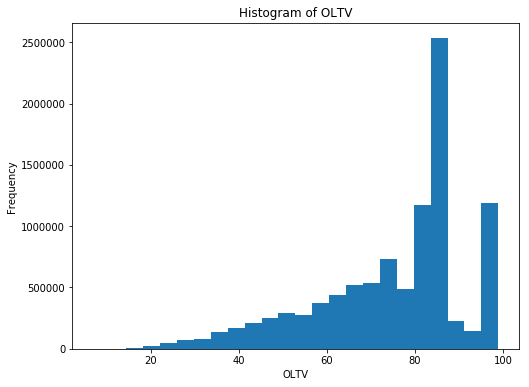

In [16]:
plt.figure(figsize=(8,6))
acquisition["OLTV"].hist()

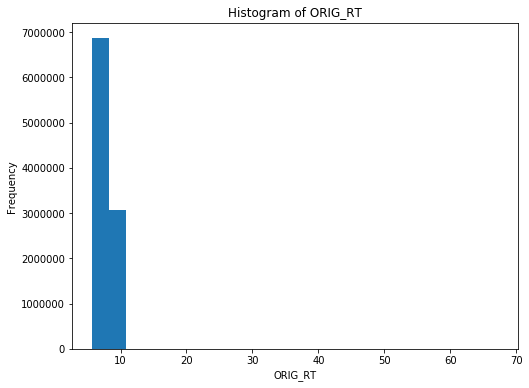

In [17]:
plt.figure(figsize=(8,6))
acquisition["ORIG_RT"].hist()

## Performance data

Each record in this data corresponds to the monthly 'performance' of a mortgage, so for each mortgage in the acquisition data set, there are multiple records in the performance data set. From the start of the mortgage up until end of 2019


### Import from zip

In [20]:
%%time

#### Import performance data
## we do not use all the 31 variables only four variables and the rest is skipped
## only the month delinquency status and the foreclosure date (if any) per mortgage
performance_Variables = [
    "LOAN_ID", "Monthly_Rpt_Prd", "Delq_Status", "Foreclosure_date"
]

performance = h2o.import_file(
    "data/performances2010_2014.zip",
    sep = "|",
    header = 0 ,
    col_names = performance_Variables,
    skipped_columns=[2,3,4,5,6,7,8,9,11,12,13,14,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30]
)

performance.shape

Parse progress: |████████████████████████████████████████████████████████ (failed)  99%


OSError: Job with key $03017f00000132d4ffffffff$_8f88869471a4e6d1253498b271c44e18 failed with an exception: DistributedException from /127.0.0.1:54321: 'Java heap space', caused by java.lang.OutOfMemoryError: Java heap space
stacktrace: 
DistributedException from /127.0.0.1:54321: 'Java heap space', caused by java.lang.OutOfMemoryError: Java heap space
	at water.MRTask.getResult(MRTask.java:488)
	at water.MRTask.getResult(MRTask.java:496)
	at water.MRTask.doAll(MRTask.java:403)
	at water.parser.ParseDataset.parseAllKeys(ParseDataset.java:254)
	at water.parser.ParseDataset.access$000(ParseDataset.java:26)
	at water.parser.ParseDataset$ParserFJTask.compute2(ParseDataset.java:203)
	at water.H2O$H2OCountedCompleter.compute(H2O.java:1551)
	at jsr166y.CountedCompleter.exec(CountedCompleter.java:468)
	at jsr166y.ForkJoinTask.doExec(ForkJoinTask.java:263)
	at jsr166y.ForkJoinPool$WorkQueue.runTask(ForkJoinPool.java:974)
	at jsr166y.ForkJoinPool.runWorker(ForkJoinPool.java:1477)
	at jsr166y.ForkJoinWorkerThread.run(ForkJoinWorkerThread.java:104)
Caused by: java.lang.OutOfMemoryError: Java heap space
	at java.base/java.util.Arrays.copyOf(Arrays.java:3818)
	at water.fvec.NewChunk$Mantissas.resize(NewChunk.java:230)
	at water.fvec.NewChunk.append2slow(NewChunk.java:981)
	at water.fvec.NewChunk.addNum(NewChunk.java:616)
	at water.parser.FVecParseWriter.addNumCol(FVecParseWriter.java:143)
	at water.parser.FVecParseWriter.addStrCol(FVecParseWriter.java:174)
	at water.parser.CsvParser.parseChunk(CsvParser.java:160)
	at water.parser.Parser.readOneFile(Parser.java:202)
	at water.parser.Parser.streamParseZip(Parser.java:232)
	at water.parser.ParseDataset$MultiFileParseTask.streamParse(ParseDataset.java:887)
	at water.parser.ParseDataset$MultiFileParseTask.map(ParseDataset.java:826)
	at water.MRTask.compute2(MRTask.java:611)
	at water.H2O$H2OCountedCompleter.compute1(H2O.java:1554)
	at water.parser.ParseDataset$MultiFileParseTask$Icer.compute1(ParseDataset$MultiFileParseTask$Icer.java)
	at water.H2O$H2OCountedCompleter.compute(H2O.java:1550)
	... 5 more


### Some explorations


In [14]:
#### How many foreclosures are there?
tfcl = performance["Foreclosure_date"].isna()
foreclosures = performance[~tfcl,:]
foreclosures.shape

(16419, 4)

A mortgage that goes into foreclosure usually has a series of 'loan delinquencies'. This can be seen in the column `Delq_Status`. Take for example the following mortgage, everything seemed to be fine up until 2017-04-01, where all of a sudden the mortgage showed delinquencies

In [15]:
tmp = performance [performance["LOAN_ID"] == 102788180928,:]
tmp.tail(15)

LOAN_ID,Monthly_Rpt_Prd,Delq_Status,Foreclosure_date
1.02788e+11,2016-12-01 00:00:00,0,
1.02788e+11,2017-01-01 00:00:00,0,
1.02788e+11,2017-02-01 00:00:00,0,
1.02788e+11,2017-03-01 00:00:00,0,
1.02788e+11,2017-04-01 00:00:00,0,
1.02788e+11,2017-05-01 00:00:00,1,
1.02788e+11,2017-06-01 00:00:00,2,
1.02788e+11,2017-07-01 00:00:00,3,
1.02788e+11,2017-08-01 00:00:00,4,
1.02788e+11,2017-09-01 00:00:00,5,


the values of the column `Delq_Status` have the following meaning:

* 0 - "Current or less than 30 days past due"
* 1 - "30 - 59 days past due"
* 2 - "60 - 89 days past due"
* 3 - "90 - 119 days past due"
* 4 - "120 - 149 days past due"
* 5 - "150 - 179 days past due"
* 6 - "180 Day Delinquency"
* 7 - "210 Day Delinquency"
* 8 - "240 Day Delinquency"
* 9 - "270 Day Delinquency" / "270+ Day Delinquency"

The following code shows an distribution of delinquency status


In [17]:
del_status = h2o.as_list(
    performance
    .group_by(["Delq_Status"])
    .count()
    .get_frame()
)

In [18]:
del_status.query("0 < Delq_Status < 10")

,Delq_Status,nrow
2,1.0,2218921
3,2.0,441117
4,3.0,196291
5,4.0,130543
6,5.0,103321
7,6.0,76454
8,7.0,59761
9,8.0,48916
10,9.0,40704


### Define a foreclosure target

merge the mortgaes in the acquisition data set with the forecloseres and create a target column

In [19]:
mortgages = acquisition.merge(
    foreclosures,
    all_x=True
)

mortgages["TARGET_FC"] = (mortgages["Foreclosure_date"].isna()).ifelse(0,1)

In [20]:
### Fore closure rate around .192%
mortgages["TARGET_FC"].mean()

[0.0019232301361902353]

In [21]:
states_foreclosures = h2o.as_list(
    mortgages
    .group_by(["STATE"])
    .mean(col="TARGET_FC", na="rm")
    .count()
    .get_frame()
)
### remove some strange states
states_foreclosures = states_foreclosures[~states_foreclosures.STATE.isin(["VI","PR", "N", "GU"])]
states_foreclosures = states_foreclosures.assign(FC_percentage = states_foreclosures.mean_TARGET_FC*100)

In [22]:
### display on map
fig = px.choropleth(
    states_foreclosures,
    locations="STATE",
    locationmode="USA-states",
    color="FC_percentage",
    hover_name="STATE", # column to add to hover information
    color_continuous_scale=px.colors.sequential.Plasma,
    scope="usa",
    width=1200,
    title = "Foreclosure percentage of 2010/11 mortgages per state"
)
fig

In [23]:
### top 10 states
states_foreclosures.sort_values("FC_percentage", ascending = False).head(10)

,STATE,mean_TARGET_FC,nrow,FC_percentage
1,AL,0.006538,100798,0.653783
26,MS,0.005823,46711,0.582304
2,AR,0.005342,54661,0.534202
53,WV,0.004929,20896,0.492917
18,KY,0.004283,74255,0.428254
38,OK,0.004178,81381,0.417788
45,TN,0.004130,134861,0.413018
17,KS,0.003793,56690,0.379256
37,OH,0.003745,212030,0.374475
25,MO,0.003656,167400,0.365591


### Delinquency target

We can also look a less severe target, instead of foreclosures we can look at 90 days paymenyt arrears 

In [24]:
delinq3 = performance [performance["Delq_Status"] == 3,:]
delinq3 = (
    delinq3
    .group_by(["LOAN_ID"])
    .count()
    .get_frame()
)

In [25]:
delinq3.shape

(93916, 2)

In [26]:
mortgages = mortgages.merge(
    delinq3,
    all_x=True
)

In [27]:
mortgages["TARGET_90days"] = (mortgages["nrow"].isna()).ifelse(0,1)

In [28]:
### foreclosure rate and 90 days arrears rate
mortgages[["TARGET_FC","TARGET_90days"]].mean()

[0.0019232301361902353, 0.011002305767229987]

In [29]:
states_90days = h2o.as_list(
    mortgages
    .group_by(["STATE"])
    .mean(col="TARGET_90days", na="rm")
    .count()
    .get_frame()
)

### remove some strange states
states_90days = states_90days[~states_90days.STATE.isin(["VI","PR", "N", "GU"])]
states_90days = states_90days.assign(Target90_percentage = states_90days.mean_TARGET_90days*100)

In [30]:
### display on map
fig = px.choropleth(
    states_90days,
    locations="STATE",
    locationmode="USA-states",
    color="Target90_percentage",
    hover_name="STATE", # column to add to hover information
    color_continuous_scale=px.colors.sequential.Plasma,
    scope="usa",
    width=1200,
    title = "90 days arrears percentage of 2010/11/12 mortgages per state"
)
fig

In [31]:
### top 10
states_90days.sort_values("Target90_percentage", ascending=False).head(10)

,STATE,mean_TARGET_90days,nrow,Target90_percentage
19,LA,0.022809,97374,2.280896
26,MS,0.021537,46711,2.153668
1,AL,0.019008,100798,1.900831
9,FL,0.018263,293817,1.826307
53,WV,0.017802,20896,1.780245
38,OK,0.017117,81381,1.711702
2,AR,0.016429,54661,1.642853
36,NY,0.015527,339475,1.552692
33,NJ,0.015506,258152,1.550637
18,KY,0.015420,74255,1.541984


In [32]:
h2o.shutdown()

H2O session _sid_ba7b closed.
